# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые для работы библиотеки.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Для работы с большим массивом фотографий воспользуемся загрузчиком данных.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
print('Количество дубликатов:', labels.duplicated().sum())
print('Количество пропусков:', labels.isnull().sum())
print(labels.describe())

Количество дубликатов: 0
Количество пропусков: file_name    0
real_age     0
dtype: int64
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


Выборка небольшая, в 5-10 раз меньше обычного, значит воспользуемся полученными знаниями и увеличим ее с помощью аугментации а конкретно горизонтального отражения и сдвига на 20%. На выходе получим почти 23 тысячи изображений, думаю для выполнения задачи этого должно хватить, все-таки при использовании слишком большого количества инструментов модель может переобучиться.

Пропусков и дубликатов в датафрейме нет, данные аж от 1 года до 100 лет, построим график.

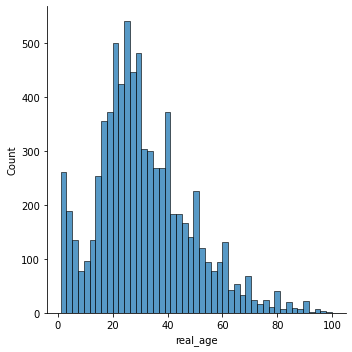

In [4]:
features, target = next(train_gen_flow)

sns_plot = sns.displot(labels['real_age'])

Подавляющее большинство - люди в возрасте от 20 до 30 лет, то есть распределение такое же как в реальной жизни, это очень важно для конечного результата. Наблюдаются пики в районе юбилейных лет, можно предположить, что у некоторых фото точный возраст был неизвестен и тот, кто размечал датасет попросту округлял его.

Выведем на экран 10 изображений.

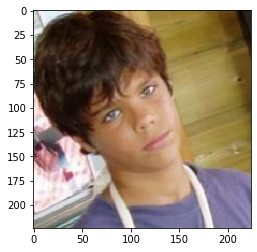

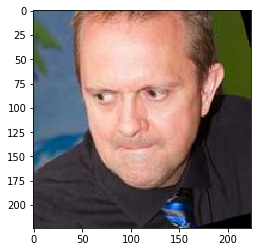

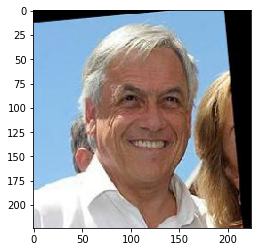

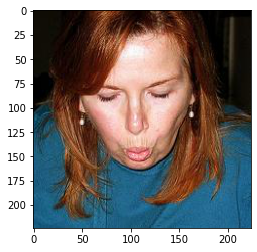

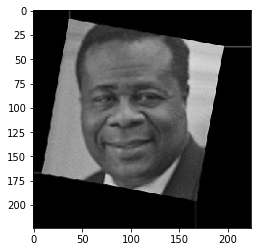

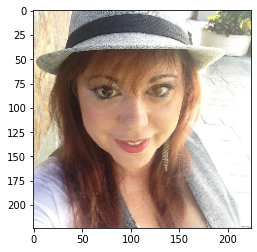

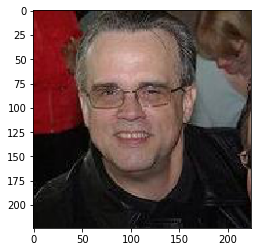

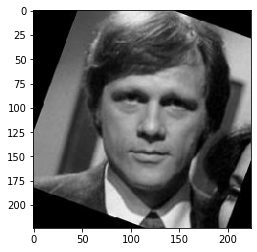

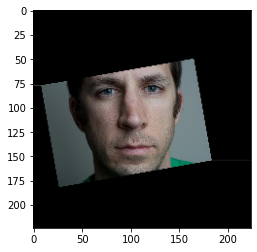

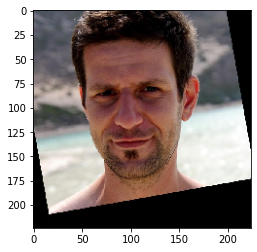

In [5]:
batch = next(train_gen_flow)
for y in range(1,11):
    plt.imshow(batch[0][y])
    plt.show()

Видно, что к выборке уже применена аугментация, что есть хорошо, то есть независимо от того как далеко человек будет стоять от камеры, под каким углом и будет ли шевелиться - наша сеть будет к такому готова.

Нам осталось лишь обучить нейросеть.

## Обучение модели

```python

import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers              import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models              import Sequential
from tensorflow.keras.optimizers          import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        rescale=1 / 255.)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1 / 255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 

    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
         steps_per_epoch = len(train_data)
    if validation_steps is None:
         validation_steps = len(test_data)

    model.fit(train_data,
               validation_data=test_data,
               batch_size=batch_size, 
               epochs=epochs,
               steps_per_epoch=steps_per_epoch,
               validation_steps=validation_steps,
               verbose=2, shuffle=True)
 
    return model
```

```


Train for 190 steps, validate for 48 steps
Epoch 1/6
2022-10-25 19:50:08.918304: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-25 19:50:09.434669: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 121s - loss: 213.6191 - mae: 10.5536 - val_loss: 881.1552 - val_mae: 24.6822
Epoch 2/6
Epoch 3/6
190/190 - 101s - loss: 82.0151 - mae: 6.8289 - val_loss: 778.5098 - val_mae: 22.8350
Epoch 4/6
190/190 - 100s - loss: 56.0293 - mae: 5.6944 - val_loss: 246.2953 - val_mae: 11.5658
190/190 - 101s - loss: 43.1177 - mae: 5.0487 - val_loss: 127.2762 - val_mae: 8.7255
Epoch 5/6
190/190 - 99s - loss: 34.5996 - mae: 4.5313 - val_loss: 78.8130 - val_mae: 6.7446
Epoch 6/6
190/190 - 102s - loss: 28.6561 - mae: 4.1500 - val_loss: 87.9916 - val_mae: 6.8428
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 87.9916 - mae: 6.8428
Test MAE: 6.8428



```

## Анализ обученной модели

В этом проекте я обучил нейросеть для определения возраста человека по фотографии.

Была проведена предобработка, данные были распределены нормально.

Для сохранения ресурсов памяти и аугментации изображений использовался ImageDataGenerator.

В качестве нейронной сети была выбрана предобученная ResNet50, мною была заменена "голова" и настроены параметры обучения под задачу.


Перед нами стояла задача определить возраст для:

- анализа покупок и последующих рекомендаций товаров для покупателей этой возрастной группы;

- контроля добросовестности кассиров при продаже алкогольной и табачной продукции.

Cредняя абсолютная ошибка составила чуть меньше 8. С таким результатом, на мой взгляд, сеть годится лишь для рекомендаций. Все-таки, как мне кажется, если бы возраст пытался предсказывать человек результаты были бы не намного лучше или даже примерно такими же, так что я считаю что нейросеть постаралась на славу.

В выборке было представлено крайне мало пожилых людей относительно других, возможно если увеличить количество фотографий с возрастом выше 50-60 лет, модель показала бы результат лучше.